In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv('/Users/singal/Desktop/MLPython_Data/titanic.csv')

# 一、数据处理
## 1、将数据框根据频次展开

In [2]:
freq=data.Freq.to_numpy()
index=np.repeat(np.arange(32),freq)
data=data.iloc[index,:]#重要
data=data.drop('Freq',axis=1)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2201 entries, 2 to 31
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Class     2201 non-null   object
 1   Sex       2201 non-null   object
 2   Age       2201 non-null   object
 3   Survived  2201 non-null   object
dtypes: object(4)
memory usage: 86.0+ KB


In [3]:
data.describe()

,Class,Sex,Age,Survived
count,2201,2201,2201,2201
unique,4,2,2,2
top,Crew,Male,Adult,No
freq,885,1731,2092,1490


## 2、观察特征向量对响应变量的影响

In [4]:
print(pd.crosstab(data.Sex,data.Survived,normalize='index'),'\n')
print(pd.crosstab(data.Age,data.Survived,normalize='index'))
pd.crosstab(data.Class,data.Survived,normalize='index')

Survived        No       Yes
Sex                         
Female    0.268085  0.731915
Male      0.787984  0.212016 

Survived        No       Yes
Age                         
Adult     0.687380  0.312620
Child     0.477064  0.522936


Survived,No,Yes
Class,,
1st,0.375385,0.624615
2nd,0.585965,0.414035
3rd,0.747875,0.252125
Crew,0.760452,0.239548


# 二、使用statsmodels模块进行逻辑回归

In [5]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from patsy import dmatrices

## 1、生成数据矩阵和响应变量
对于分类问题，应采取分层抽样的方式划分训练集和测试集。

In [6]:
train,test=train_test_split(data,test_size=0.3,stratify=data.Survived,random_state=0)#stratify表示分层抽样

In [7]:
ytrain,xtrain=dmatrices('Survived~Class+Sex+Age',data=train,return_type='dataframe')#'Treatment Coding'='Dummy Coding'
print(ytrain.head())
xtrain.head()

    Survived[No]  Survived[Yes]
11           1.0            0.0
27           0.0            1.0
22           0.0            1.0
11           1.0            0.0
27           0.0            1.0


,Intercept,Class[T.2nd],Class[T.3rd],Class[T.Crew],Sex[T.Male],Age[T.Child]
11,1.0,0.0,0.0,1.0,1.0,0.0
27,1.0,0.0,0.0,1.0,1.0,0.0
22,1.0,0.0,1.0,0.0,0.0,1.0
11,1.0,0.0,0.0,1.0,1.0,0.0
27,1.0,0.0,0.0,1.0,1.0,0.0


In [8]:
ytrain=ytrain.drop('Survived[No]',axis=1)

In [9]:
ytest,xtest=dmatrices('Survived~Class+Sex+Age',data=test,return_type='dataframe')
ytest=ytest.drop('Survived[No]',axis=1)

## 2、逻辑回归，生成混淆矩阵

In [10]:
res=sm.Logit(ytrain,xtrain).fit()#根据梯度向量和黑塞矩阵进行牛顿法迭代求解

Optimization terminated successfully.
         Current function value: 0.501935
         Iterations 6


计算几率比，结论如下：
1. 给定其他特征变量，当乘客由成年变为小孩，其存活的新几率比是原先的3.09倍。
2. 二等舱乘客存活几率比是一等舱乘客的0.35倍。

In [11]:
np.exp(res.params)

Intercept        7.564391
Class[T.2nd]     0.351384
Class[T.3rd]     0.154262
Class[T.Crew]    0.413685
Sex[T.Male]      0.094819
Age[T.Child]     3.086208
dtype: float64

In [12]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:          Survived[Yes]   No. Observations:                 1540
Model:                          Logit   Df Residuals:                     1534
Method:                           MLE   Df Model:                            5
Date:                Sun, 29 Aug 2021   Pseudo R-squ.:                  0.2019
Time:                        12:49:58   Log-Likelihood:                -772.98
converged:                       True   LL-Null:                       -968.52
Covariance Type:            nonrobust   LLR p-value:                 2.482e-82
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.0235      0.200     10.141      0.000       1.632       2.415
Class[T.2nd]     -1.0459      0.232     -4.509      0.000      -1.501      -0.591
Class[T.3rd]     -1.8691      0.206     

In [13]:
table=res.pred_table()#计算训练集的混淆矩阵
print(table)

[[949.  94.]
 [252. 245.]]


每行为实际值，每列为预测值，如预测存活但实际不存活的人数为94

In [14]:
accuracy=(table[0,0]+table[1,1])/np.sum(table)
error_rate=1-accuracy
sensitivity=table[1,1]/(table[1,0]+table[1,1])
specificity=table[0,0]/(table[0,0]+table[0,1])
print('预测准确率为',accuracy,sep='：')
print('灵敏度为',sensitivity,sep='：')
print('特异度为：',specificity,sep='')

预测准确率为：0.7753246753246753
灵敏度为：0.49295774647887325
特异度为：0.909875359539789


## 3、计算测试集的混淆矩阵

In [15]:
prob=res.predict(xtest)
pred=(prob>=0.5)#得到布尔型
ytest['pred']=pred
table=pd.crosstab(ytest['Survived[Yes]'],ytest['pred'])
ytest=ytest.iloc[:,0]
table

pred,False,True
Survived[Yes],,
0.0,415,32
1.0,110,104


为方便计算，将dataframe转换为array。

In [16]:
table=np.array(table)
table

array([[415,  32],
       [110, 104]])

In [17]:
accuracy=(table[0,0]+table[1,1])/np.sum(table)
error_rate=1-accuracy
sensitivity=table[1,1]/(table[1,0]+table[1,1])
specificity=table[0,0]/(table[0,0]+table[0,1])
print('预测准确率为',accuracy,sep='：')
print('灵敏度为',sensitivity,sep='：')
print('特异度为：',specificity,sep='')

预测准确率为：0.7851739788199698
灵敏度为：0.48598130841121495
特异度为：0.9284116331096197


# 三、使用sklearn模块进行逻辑回归

In [18]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as lr
import sklearn.metrics as sms

## 1、逻辑回归
sklearn模块只能估计带有惩罚项的逻辑回归，故本例中需设置极为接近于0的惩罚项C。

In [19]:
model=lr(C=1e10)#C表示惩罚力度的倒数，故惩罚力度可视为0
model.fit(xtrain,ytrain)

/Users/singal/miniforge3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=10000000000.0)

In [20]:
model.coef_

array([[ 1.01172396, -1.04587333, -1.86910362, -0.88265229, -2.35577901,
         1.1269402 ]])

In [21]:
model.score(xtest,ytest)#二值选择模型中输出准确率

0.7851739788199698

## 2、计算测试集的混淆矩阵

In [22]:
print(model.predict(xtest)[:5])
print(model.predict_proba(xtest)[:5])

[1. 0. 0. 0. 1.]
[[0.24217431 0.75782569]
 [0.90037827 0.09962173]
 [0.90037827 0.09962173]
 [0.77117951 0.22882049]
 [0.2733733  0.7266267 ]]


pandas中crosstab函数与sklearn中confusion_matrix的用法功能相同，区别是前者生成dataframe，后者生成array。

In [23]:
pd.crosstab(ytest,model.predict(xtest))

col_0,0.0,1.0
Survived[Yes],,
0.0,415,32
1.0,110,104


In [24]:
sms.confusion_matrix(ytest,model.predict(xtest))

array([[415,  32],
       [110, 104]])

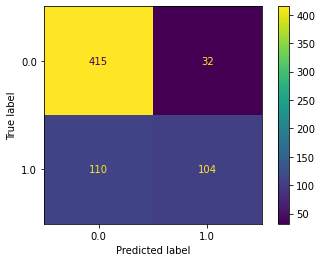

In [25]:
sms.plot_confusion_matrix(model,xtest,ytest)

使用classification_report函数计算混淆矩阵的统计指标。

In [26]:
print(sms.classification_report(ytest,model.predict(xtest),target_names=['Not Survived','Survived']))

              precision    recall  f1-score   support

Not Survived       0.79      0.93      0.85       447
    Survived       0.76      0.49      0.59       214

    accuracy                           0.79       661
   macro avg       0.78      0.71      0.72       661
weighted avg       0.78      0.79      0.77       661



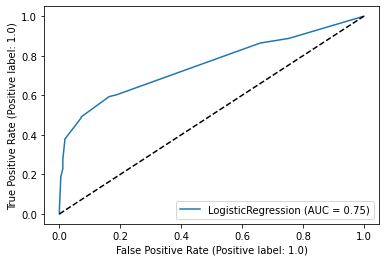

In [27]:
sms.plot_roc_curve(model,xtest,ytest)
x=np.linspace(0,1,100)
plt.plot(x,x,'k--')

In [28]:
sms.cohen_kappa_score(ytest,model.predict(xtest))

0.4578900555613312

科恩的kappa为：
$$kappa=\frac{P_O-P_E}{1-P_E}$$
分子是从随机一致性到观测一致性的改进，分母为从随机一致性到完全一致的最大可能改进，其中：
$$P_O=p_{11}+p_{22} \quad and \quad P_E=p_1^2+p_2^2$$